# Immunogenicity

IEDB.org 

In [1]:
# many functions have been defined but written down in different ipynb files, for clarity. Import those (%run)
%run Functions.ipynb
%run Functions_visualization.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
%store -r peptideseqs_clades
# peptideseqs_clades dictionary will form the basis of this analysis, as we again need the epitope sequences in order
# to run them through the immunogenicity predictor

In [3]:
# 3-step functions to generate complete list of all (unique) epitopes that are presented by all alleles analysed
def per_clade(allele, protein, clade):
    nested = [peptideseqs_clades[allele][protein][clade][strain] 
             for strain in peptideseqs_clades[allele][protein][clade]]
    return [item for sublist in nested for item in sublist]

def per_protein(allele, protein):
    nested = [per_clade(allele, protein, clade) for clade in peptideseqs_clades[allele][protein]]
    return [item for sublist in nested for item in sublist]

def per_allele(allele):
    nested = [per_protein(allele, protein) for protein in peptideseqs_clades[allele]]
    return [item for sublist in nested for item in sublist]

totalnested = [per_allele(allele) for allele in peptideseqs_clades]
total = list(set([item for sublist in totalnested for item in sublist]))

In [22]:
# this list of epitopes is then formatted into txt file with each epitope on its own line, to allow input in IEDB.org
with open('/Users/pcevaal/Desktop/TheoreticalBiol/Peptides-xx.txt', 'w') as f:
    for peptide in total:
        f.write(peptide + '\n')

### Run IEDB immunogenicity prediction for all peptides
Those containing 'X' have been excluded in earlier stage (generation of peptideseqs_clades dictionary)

Input file: Peptides-xx.txt  
Output file: Result_peptides-xx.csv

In [7]:
immunogenicity = pd.read_csv('/Users/pcevaal/Desktop/TheoreticalBiol/Result_peptides-xx.csv') # open IEDB output

In [8]:
# transform IEDB output dataframe into dictionary for easier further use
imgen_dict = {} # initiate
for y in range(len(immunogenicity)): # for all alleles
    imgen_dict[immunogenicity.loc[y,'peptide']] = immunogenicity.loc[y,'score'] # make dict entry with peptide seq as key, immunogenicity score as value

In [10]:
# aim to generate dictionary containing the immunogenicity for each presented epitope. Use dict structure as in 
# epitope conservation studies, but amend values from conservation score to immunogenicity score
%store -r peptideseqs
immunogenicity_epis_all = conserved_epitopes_all(peptideseqs, 0.0) # generate new copy of conserved epitopes dict
for allele in immunogenicity_epis_all:
    for protein in immunogenicity_epis_all[allele]:
        for strain in immunogenicity_epis_all[allele][protein]:
            for epitope in immunogenicity_epis_all[allele][protein][strain]:
                    immunogenicity_epis_all[allele][protein][strain][epitope] = imgen_dict[epitope] # change value to immunogenity score

#### Averaging stepwise;  av of epitopes within one strain, av of all strains per protein, av of all proteins per allele

In [11]:
imgen_per_allele = {} # initiate new dict that will give average immunogenicity score per allele
for allele in immunogenicity_epis_all:
    proteins = []
    for protein in immunogenicity_epis_all[allele]:
        strains = []
        for strain in immunogenicity_epis_all[allele][protein]:
            list1 = [immunogenicity_epis_all[allele][protein][strain][epitope] # make list of all immunogenicity scores
                                 for epitope in immunogenicity_epis_all[allele][protein][strain]] # of all epitopes
            if len(list1) != 0: # HLA-B18:01 does not present any epitopes from Ref.A1.RW so would yield NaN
                strainmean = np.mean(list1) # take mean of immunogenicity score of presented epitopes from this strain
                strains.append(strainmean) # add mean of strain to list
        proteinmean = np.mean(strains) # average from all strains
        proteins.append(proteinmean) # add mean of protein to list
    allelemean = np.mean(proteins) # average from all proteins
    imgen_per_allele[allele] = allelemean # assign mean of allele to final dictionary

MannwhitneyuResult(statistic=49.0, pvalue=0.10136508532326127)


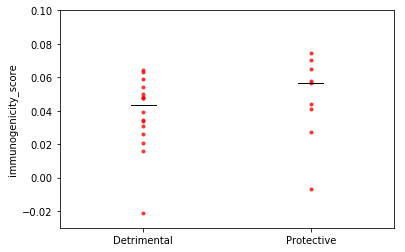

In [13]:
# prepare imgen_per_allele dataframe into format that can be used for plotting, 
# and perform MannWhitneyU test (unpaired, non-parametrical, one-sided)
df = scatterplot_matrixprep(imgen_per_allele, 'immunogenicity')
#print df
scatter_dot_plot_mannwhitney(df, 'immunogenicity', 'immunogenicity_score', -0.03, 0.1)

#### Averaging in one go; make set of all epitopes presented by one allele, average that

Difference with above is that, in above case, epitopes that are present in multiple strains (which is very realistic) will be taken into account multiple times. This basically scews the result (immunogenicity score) towards the values belonging to more conserved peptides. One could therefore argue that above situation is a combined analysis of conservation and immunogenicity, and therefore not the best approach.   
Below situation firstly makes a list for each allele of all epitopes presented of all strains, proteins. It then makes a unique set of these epitopes, i.e. taking out duplicates ('conserved epitopes'), and only counts each unique epitope once when calculating the average immunogenicity score for the group of epitopes presented by that allele

In [14]:
# 2-step functions to generate complete list of all (unique) epitopes that are presented by all alleles analysed
def per_protein2(allele, protein):
    nested = [immunogenicity_epis_all[allele][protein][strain] for strain in immunogenicity_epis_all[allele][protein]]
    return [item for sublist in nested for item in sublist]

def per_allele2(allele):
    nested = [per_protein2(allele, protein) for protein in immunogenicity_epis_all[allele]]
    return list(set([item for sublist in nested for item in sublist]))

# for each allele, generate list of unique peptides presented
totalnested = {allele:per_allele2(allele) for allele in immunogenicity_epis_all}
imgen_per_allele_set = {} # initiate
for allele in totalnested:
    imgenscore_list = [] # initiate
    for epitope in totalnested[allele]: # for each epitope in unique list of presented peptides
        imgenscore_list.append(imgen_dict[epitope]) # add immunogenicity score to list
    allelemean = np.mean(imgenscore_list) # take mean of these immunogenicity scores; each conserved epitope is only taken into account once in averaging
    imgen_per_allele_set[allele] = allelemean  # assign to allele key in dictionary

MannwhitneyuResult(statistic=67.0, pvalue=0.39945333482163486)


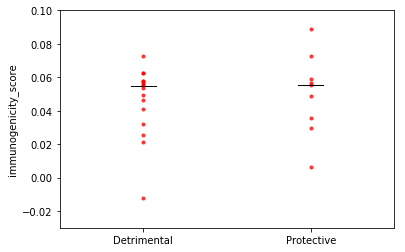

In [17]:
df_set = scatterplot_matrixprep(imgen_per_allele_set, 'immunogenicity')
#print df_set
scatter_dot_plot_mannwhitney(df_set, 'immunogenicity', 'immunogenicity_score', -0.03, 0.1)